# Activité : modèles de séries temporelles

<img src="https://cdn.pixabay.com/photo/2013/07/12/16/01/clock-150754_1280.png" alt="horloge" width="400"/>

## 🔍 Recherche d'informations

En recherchant sur le web, trouver les réponses aux questions suivantes :

### - Comment est effectuée la séparation entre le jeu de données d'entrainement et de test pour des séries temporelles ?
___
La séparation est effectuée en conservant l'ordre des données.
___
### - Comment peut-on effectuer une séparation proche de la validation croisée avec des séries temporelles ?
___
On peut utiliser la méthode "TimeSeriesSplit" de Scikit-learn qui conserve l'ordre des données

Source : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
___
### - A quoi sert le modèle ARIMA ?
___
Le **modèle ARIMA** permet de faire de la **prédiction avec des séries temporelles**. Il a une partie qui se base sur de l'**autorégression** et une partie sur des **moyennes mobiles**.

Source : https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
___
## 💻 Jeux de données utilisés :

- Jeu de données des cours des actions du CAC40 de la bourse de Paris entre 2010 et 2021 : https://raw.githubusercontent.com/Pierre-Loic/Datasets/main/CAC40_stocks_2010_2021.csv

- Jeu de données des températures quotidiennes régionales (depuis janvier 2016) : https://www.data.gouv.fr/fr/datasets/temperature-quotidienne-regionale-depuis-janvier-2016/

## Création d'un modèle de régression linéaire pour la partie auto-régression (AR)

- Récupérer les données **températures quotidiennes régionales** dans un **dataframe Pandas** avec les étapes de pré-traitement du notebook d'EDA. Conserver uniquement la **température moyenne "tmoy"** en région Auvergne-Rhône-Alpes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url_temperatures = "https://www.data.gouv.fr/fr/datasets/r/50b3f76f-b20c-4095-b3f1-96f5e26cbac6"
df_temperature = pd.read_csv(url_temperatures, sep=";")
df_temperature

id        date  code_insee_region  \
0      2021-09-19T00:00:00-94  2021-09-19                 94   
1      2021-09-19T00:00:00-93  2021-09-19                 93   
2      2021-09-19T00:00:00-44  2021-09-19                 44   
3      2021-09-20T00:00:00-28  2021-09-20                 28   
4      2021-09-20T00:00:00-76  2021-09-20                 76   
...                       ...         ...                ...   
34341  2023-03-30T00:00:00-75  2023-03-30                 75   
34342  2023-03-30T00:00:00-28  2023-03-30                 28   
34343  2023-03-30T00:00:00-94  2023-03-30                 94   
34344  2023-03-31T00:00:00-94  2023-03-31                 94   
34345  2023-03-31T00:00:00-27  2023-03-31                 27   

                           region   tmin   tmax   tmoy  
0                           Corse  18.20  26.90  22.55  
1      Provence-Alpes-Côte d'Azur  14.83  23.30  19.07  
2                       Grand Est  10.41  16.76  13.59  
3                       Normandie  12.92  18.84  15.88  
4                       Occitanie  13.83  20.48  17.15  
...                           ...    ...    ...    ...  
34341          Nouvelle-Aquitaine  11.14  19.33  15.24  
34342                   Normandie  11.02  15.98  13.50  
34343                       Corse   7.30  18.95  13.12  
34344                       Corse   7.20  19.45  13.32  
34345     Bourgogne-Franche-Comté   9.15  15.72  12.43  

[34346 rows x 7 columns]

In [3]:
df_temperature = df_temperature.astype({
    'date': 'datetime64[ns]',
    'region': 'category',
})

In [4]:
useful_col = ["date", "region", "tmin", "tmax", "tmoy"]
df_temperature = df_temperature[useful_col]

In [5]:
df_temperature = df_temperature.set_index("date")

In [6]:
df_aura = df_temperature[df_temperature["region"]=="Auvergne-Rhône-Alpes"]
df_aura = df_aura.sort_index()

In [7]:
df_aura = df_aura.resample("D").ffill()

In [8]:
df_aura_ini = df_aura[["tmoy"]]

## Ingénierie des caractéristiques

- Créer deux **nouvelles caractéristiques** de la **température moyenne décalée** de un jour et de 2 jours

In [9]:
temp = pd.DataFrame()
temp[f"shift_1"] = df_aura_ini.shift(periods=1)
temp[f"shift_2"] = df_aura_ini.shift(periods=2)
df_aura = pd.concat([df_aura_ini, temp], axis=1)
df_aura

tmoy  shift_1  shift_2
date                               
2016-01-01   6.76      NaN      NaN
2016-01-02   7.20     6.76      NaN
2016-01-03   5.08     7.20     6.76
2016-01-04   7.17     5.08     7.20
2016-01-05   7.01     7.17     5.08
...           ...      ...      ...
2023-03-27   6.30    10.06    10.61
2023-03-28   6.54     6.30    10.06
2023-03-29  14.01     6.54     6.30
2023-03-30  14.58    14.01     6.54
2023-03-31  12.91    14.58    14.01

[2647 rows x 3 columns]

- Supprimer les **valeurs manquantes**

In [10]:
df_aura = df_aura.dropna()
df_aura

tmoy  shift_1  shift_2
date                               
2016-01-03   5.08     7.20     6.76
2016-01-04   7.17     5.08     7.20
2016-01-05   7.01     7.17     5.08
2016-01-06   5.15     7.01     7.17
2016-01-07   6.84     5.15     7.01
...           ...      ...      ...
2023-03-27   6.30    10.06    10.61
2023-03-28   6.54     6.30    10.06
2023-03-29  14.01     6.54     6.30
2023-03-30  14.58    14.01     6.54
2023-03-31  12.91    14.58    14.01

[2645 rows x 3 columns]

- Séparer la **feature décalée de un jour** de la **valeur cible tmoy**

In [11]:
X, y = df_aura[["shift_1", "shift_2"]], df_aura["tmoy"]

In [12]:
y

date
2016-01-03     5.08
2016-01-04     7.17
2016-01-05     7.01
2016-01-06     5.15
2016-01-07     6.84
              ...  
2023-03-27     6.30
2023-03-28     6.54
2023-03-29    14.01
2023-03-30    14.58
2023-03-31    12.91
Freq: D, Name: tmoy, Length: 2645, dtype: float64

- A l'aide de la bibliothèque **Scikit-learn**, créer un **modèle de régression linéaire** qui s'entraine sur **tout le jeu de données** sauf la **dernière valeur**

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [14]:
reg = LinearRegression().fit(X[:-1], y[:-1])
print(f"Valeur réelle : {y[-1]}")
print(f"Valeur prédite : {round(reg.predict(pd.DataFrame(X.iloc[-1]).T)[0], 2)}")

Valeur réelle : 12.91
Valeur prédite : 14.54


- Récupérer les **coefficients de la régression linéaire**

In [15]:
reg.coef_

array([ 1.06416402, -0.10858643])

- A l'aide de la bibliothèque **Statsmodels**, utiliser un modèle **ARIMA** d'**ordre 2 en auto-régression** pour rétrouver le résultat de la question précédente

In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
model = ARIMA(y[:-1], order=(2,0,0))
results = model.fit()

In [18]:
results.predict("2023-03-31")

2023-03-31    14.540608
Freq: D, dtype: float64

- Retrouver les **coefficients de la régression linéaire**

In [19]:
results.arparams

array([ 1.06462391, -0.10905004])

- A l'aide de la **régression linèaire**, calculer les **100 dernières valeurs** (attention à la fuite de données!)

In [20]:
y_pred = []
for i in range(1, 101):
    reg = LinearRegression().fit(X[:-i], y[:-i])
    y_pred.append(reg.predict(pd.DataFrame(X.iloc[-i]).T)[0])
y_pred = y_pred[::-1]

- Calculer les **métriques RMSE et MAE** pour ces 100 valeurs

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [22]:
print(f"MAE = {mean_absolute_error(y[-100:], y_pred)}")
print(f"RMSE = {mean_squared_error(y[-100:], y_pred, squared=True)}")

MAE = 1.6892478933372466
RMSE = 4.88571986567141


- Afficher la courbe de **données réelles et prédites**

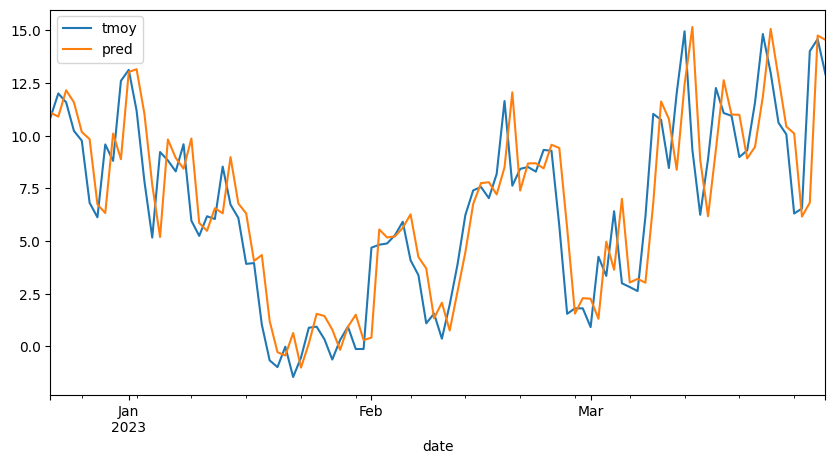

In [23]:
df_pred = pd.concat([pd.DataFrame(y[-100:]), pd.DataFrame({"pred":y_pred}, index=y[-100:].index)], axis=1)
df_pred.plot(figsize=(10, 5))
plt.show()

- Afficher la **courbe des résidus**

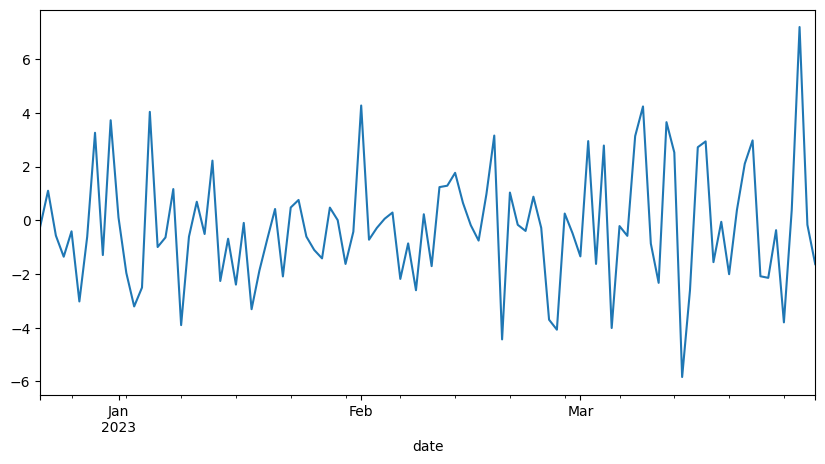

In [24]:
df_res = df_pred["tmoy"]-df_pred["pred"]
df_res.plot(figsize=(10, 5))
plt.show()

## Utilisation d'un modèle ARIMA

- Afficher le **graphique d'autocorrélation et d'autocorrélation partielle** pour tmoy et interpréter les résultats. Que peut-on déduire de la forme du graphique d'autocorrélation ?

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
plot_acf(df_aura_ini, lags=100)
plt.show()

In [ ]:
plot_pacf(df_aura_ini, lags=10)
plt.show()

- Afficher le **graphique d'autocorrélation et d'autocorrélation partielle** pour tmoy(t)-tmoy(t-1). Analyser les résultats

In [ ]:
df_I1 = (df_aura_ini-df_aura_ini.shift(periods=1)).dropna()
plot_acf(df_I1, lags=10)
plt.show()

In [ ]:
plot_pacf(df_I1, lags=10)
plt.show()

- Grâce aux graphiques précédents, en déduire les **coefficients des parties AR, I et MA** du modèle. Entrainer un modèle **ARIMA avec ces valeurs** en séparant un jeu de données d'entrainement et de test.

In [ ]:
y_train, y_test = y[:-10], y[-10:]

In [ ]:
model = ARIMA(y_train, order=(1,1,4))
results = model.fit()

In [ ]:
result = results.predict(y[-10:].index[0].date(), y[-10:].index[-1].date())
result

In [ ]:
y[-10:]

- Analyser la **qualité des pédictions**

In [ ]:
plt.plot(y[-10:])
plt.plot(result)
plt.ylim(0,15)
plt.show()

## 🚀 Pour aller plus loin

- [Interpreting ACF and PACF Plots for Time Series Forecasting](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)
- [Série temporelle - Wikipedia](https://fr.wikipedia.org/wiki/S%C3%A9rie_temporelle)